In [5]:
# Step 1: 导入库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# 禁用科学计数法显示（可选）
pd.set_option('display.float_format', lambda x: '%.5f' % x)

# Step 2: 加载数据
# 定义文件夹路径和文件名
data_folder = '../depth-data'  # 相对路径指向depth-data文件夹
files = ['data_BTC_aevo.csv', 'data_BTC-USD_dydx.csv', 'data_BTCUSDC_apex.csv']

# 创建一个空的DataFrame列表
dataframes = []

# 遍历文件列表，读取每个文件，并将它们添加到dataframes列表中
for file in files:
    file_path = os.path.join(data_folder, file)
    # 读取CSV文件，跳过第一行（标题行），并手动指定列名
    df = pd.read_csv(file_path, skiprows=1, names=['price', 'size', 'type', 'timestamp'])
    # 添加交易所名称列
    exchange_name = file.split('_')[2].split('.')[0]  # 提取交易所名称
    df['Exchange'] = exchange_name
    dataframes.append(df)

# 将所有DataFrame合并为一个
data = pd.concat(dataframes, ignore_index=True)


# 输出数据的前几行，检查加载情况
print("Loaded data preview:")
print(data.head())


Loaded data preview:
        price    size type   timestamp Exchange
0 63348.20000 0.15700  bid  1719817383     aevo
1 63360.80000 2.20000  ask  1719817383     aevo
2 63348.40000 0.16600  bid  1719817384     aevo
3 63361.40000 2.20000  ask  1719817384     aevo
4 63348.40000 0.16600  bid  1719817385     aevo


In [7]:
# Step 1: 数据清洗和准备
# 过滤掉非 bid 和 ask 的类型（假设只分析 bid 的价格差）
data_filtered = data[data['type'] == 'bid']

# 创建一个 DataFrame 以存储每个交易所的价格
# 首先，将数据按照 timestamp 和 Exchange 分组，并取 bid 的平均值
data_pivot = data_filtered.pivot_table(index='timestamp', columns='Exchange', values='price')

# 查看数据的前几行，检查数据准备情况
print("Data prepared for price spread calculation:")
print(data_pivot.head())

Data prepared for price spread calculation:
Exchange    aevo        apex        dydx
timestamp                               
1719817355   NaN 63382.50000 63349.00000
1719817360   NaN 63382.50000         NaN
1719817362   NaN         NaN 63349.00000
1719817363   NaN         NaN 63350.00000
1719817364   NaN 63382.50000 63349.00000


In [10]:
# Step 2: 计算百分比价差
# 创建一个新的 DataFrame 用于存储百分比价差
percentage_spreads = pd.DataFrame(index=data_pivot.index)

# 计算 aevo 和 dydx 之间的百分比价差，只包括两者都有价格数据的时间戳
aevo_dydx_avg = (data_pivot['aevo'] + data_pivot['dydx']) / 2
percentage_spreads['Percentage_Spread_aevo_dydx'] = ((data_pivot['aevo'] - data_pivot['dydx']) / aevo_dydx_avg) * 100
percentage_spreads['Percentage_Spread_aevo_dydx'] = percentage_spreads['Percentage_Spread_aevo_dydx'].dropna()

# 计算 aevo 和 apex 之间的百分比价差，只包括两者都有价格数据的时间戳
aevo_apex_avg = (data_pivot['aevo'] + data_pivot['apex']) / 2
percentage_spreads['Percentage_Spread_aevo_apex'] = ((data_pivot['aevo'] - data_pivot['apex']) / aevo_apex_avg) * 100
percentage_spreads['Percentage_Spread_aevo_apex'] = percentage_spreads['Percentage_Spread_aevo_apex'].dropna()

# 计算 dydx 和 apex 之间的百分比价差，只包括两者都有价格数据的时间戳
dydx_apex_avg = (data_pivot['dydx'] + data_pivot['apex']) / 2
percentage_spreads['Percentage_Spread_dydx_apex'] = ((data_pivot['dydx'] - data_pivot['apex']) / dydx_apex_avg) * 100
percentage_spreads['Percentage_Spread_dydx_apex'] = percentage_spreads['Percentage_Spread_dydx_apex'].dropna()

# 查看百分比价差的前几行
print("Percentage price spreads calculated:")
print(percentage_spreads.head())


Percentage price spreads calculated:
            Percentage_Spread_aevo_dydx  Percentage_Spread_aevo_apex  \
timestamp                                                              
1719817355                          NaN                          NaN   
1719817360                          NaN                          NaN   
1719817362                          NaN                          NaN   
1719817363                          NaN                          NaN   
1719817364                          NaN                          NaN   

            Percentage_Spread_dydx_apex  
timestamp                                
1719817355                     -0.05287  
1719817360                          NaN  
1719817362                          NaN  
1719817363                          NaN  
1719817364                     -0.05287  


In [13]:
# Step 3: 统计分析
# 描述性统计
print("Descriptive statistics for percentage price spreads:")
print(percentage_spreads.describe())

# 计算价差大于千2（0.2%）的数量
threshold = 0.2  # 千2表示 0.2%

# 计算每对交易所之间价差大于千2的数量
count_aevo_dydx_above_threshold = (abs(percentage_spreads['Percentage_Spread_aevo_dydx']) > threshold).sum()
count_aevo_apex_above_threshold = (abs(percentage_spreads['Percentage_Spread_aevo_apex']) > threshold).sum()
count_dydx_apex_above_threshold = (abs(percentage_spreads['Percentage_Spread_dydx_apex']) > threshold).sum()

print(f"Number of times the spread between Aevo and DyDx exceeds {threshold}%: {count_aevo_dydx_above_threshold}")
print(f"Number of times the spread between Aevo and Apex exceeds {threshold}%: {count_aevo_apex_above_threshold}")
print(f"Number of times the spread between DyDx and Apex exceeds {threshold}%: {count_dydx_apex_above_threshold}")

# 计算总时间戳数
total_timestamps_aevo_dydx = len(percentage_spreads['Percentage_Spread_aevo_dydx'])
total_timestamps_aevo_apex = len(percentage_spreads['Percentage_Spread_aevo_apex'])
total_timestamps_dydx_apex = len(percentage_spreads['Percentage_Spread_dydx_apex'])

# 计算大于千2价差的时间戳占比
percentage_aevo_dydx_above_threshold = (count_aevo_dydx_above_threshold / total_timestamps_aevo_dydx) * 100
percentage_aevo_apex_above_threshold = (count_aevo_apex_above_threshold / total_timestamps_aevo_apex) * 100
percentage_dydx_apex_above_threshold = (count_dydx_apex_above_threshold / total_timestamps_dydx_apex) * 100

print(f"Percentage of times the spread between Aevo and DyDx exceeds {threshold}%: {percentage_aevo_dydx_above_threshold:.2f}%")
print(f"Percentage of times the spread between Aevo and Apex exceeds {threshold}%: {percentage_aevo_apex_above_threshold:.2f}%")
print(f"Percentage of times the spread between DyDx and Apex exceeds {threshold}%: {percentage_dydx_apex_above_threshold:.2f}%")

Descriptive statistics for percentage price spreads:
       Percentage_Spread_aevo_dydx  Percentage_Spread_aevo_apex  \
count                  57576.00000                  17287.00000   
mean                       0.03668                     -0.03629   
std                        0.02048                      0.02519   
min                       -0.14611                     -0.20207   
25%                        0.02304                     -0.05175   
50%                        0.03651                     -0.03977   
75%                        0.04845                     -0.02820   
max                        0.36347                      0.10971   

       Percentage_Spread_dydx_apex  
count                  42998.00000  
mean                      -0.06652  
std                        0.01796  
min                       -0.27226  
25%                       -0.07722  
50%                       -0.06606  
75%                       -0.05540  
max                        0.07319  
Number of 

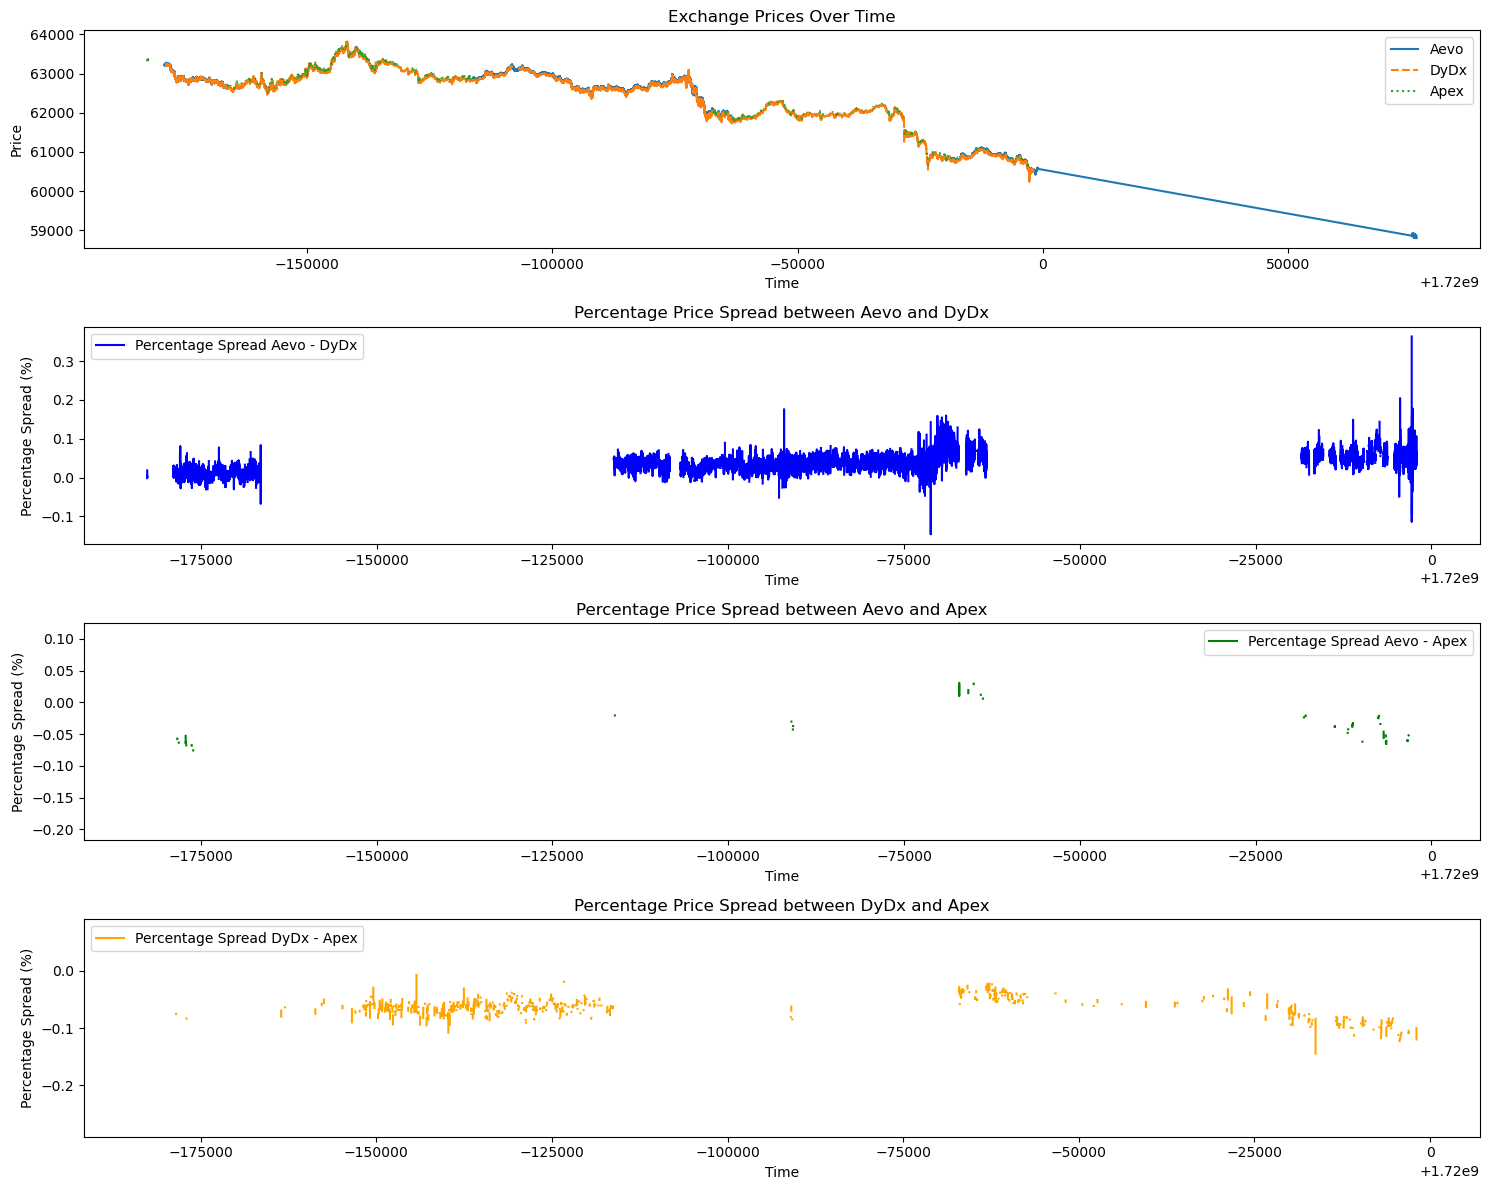

In [12]:
# Step 4: 可视化
plt.figure(figsize=(15, 12))

# 绘制交易所价格的时间序列图
plt.subplot(4, 1, 1)
plt.plot(data_pivot.index, data_pivot['aevo'], label='Aevo', linestyle='-')
plt.plot(data_pivot.index, data_pivot['dydx'], label='DyDx', linestyle='--')
plt.plot(data_pivot.index, data_pivot['apex'], label='Apex', linestyle=':')
plt.title('Exchange Prices Over Time')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()

# 绘制 aevo 和 dydx 之间的百分比价差时间序列图
plt.subplot(4, 1, 2)
plt.plot(percentage_spreads.index, percentage_spreads['Percentage_Spread_aevo_dydx'], label='Percentage Spread Aevo - DyDx', color='blue')
plt.title('Percentage Price Spread between Aevo and DyDx')
plt.xlabel('Time')
plt.ylabel('Percentage Spread (%)')
plt.legend()

# 绘制 aevo 和 apex 之间的百分比价差时间序列图
plt.subplot(4, 1, 3)
plt.plot(percentage_spreads.index, percentage_spreads['Percentage_Spread_aevo_apex'], label='Percentage Spread Aevo - Apex', color='green')
plt.title('Percentage Price Spread between Aevo and Apex')
plt.xlabel('Time')
plt.ylabel('Percentage Spread (%)')
plt.legend()

# 绘制 dydx 和 apex 之间的百分比价差时间序列图
plt.subplot(4, 1, 4)
plt.plot(percentage_spreads.index, percentage_spreads['Percentage_Spread_dydx_apex'], label='Percentage Spread DyDx - Apex', color='orange')
plt.title('Percentage Price Spread between DyDx and Apex')
plt.xlabel('Time')
plt.ylabel('Percentage Spread (%)')
plt.legend()

plt.tight_layout()
plt.show()